## Семинар 6: "Архитектуры и transfer learning"

ФИО: Кафанов Олег Игоревич

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision import models


%matplotlib inline

/home/fox/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from __future__ import print_function, division
import os
import pandas as pd
from skimage import io, transform
from torchvision import transforms, utils
import random

На этом семинаре мы попробуем улучшить результаты, полученные на занятии номер 3 с помощью Transfer Learning

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
landmarks_frame = pd.read_csv('../Sem 3/dataset/train/face_landmarks.csv')

In [5]:
X_train = []
y_train = []
for n in range(landmarks_frame.shape[0]):
    img_name = landmarks_frame.ix[n, 0]
    landmarks = landmarks_frame.ix[n, 1:].as_matrix().astype('float')
    y_train += [landmarks.reshape(-1, 2)]
    X_train += [io.imread(os.path.join('../Sem 3/dataset/train/', img_name))]

In [6]:
landmarks_frame_test = pd.read_csv('../Sem 3/dataset/test/face_landmarks.csv')

In [7]:
X_test = []
y_test = []
for n in range(landmarks_frame_test.shape[0]):
    img_name = landmarks_frame_test.ix[n, 0]
    landmarks = landmarks_frame_test.ix[n, 1:].as_matrix().astype('float')
    y_test += [landmarks.reshape(-1, 2)]
    X_test += [io.imread(os.path.join('../Sem 3/dataset/test/', img_name))]

In [8]:
X_train_new = []
for X in X_train:
    X_train_new += [X.reshape(1,96,96)]
X_train_new = np.concatenate(X_train_new, axis = 0)
y_train_new = []
for y in y_train:
    y_train_new += [y.reshape(-1,1).T]
y_train_new = np.concatenate(y_train_new)

In [9]:
X_train = torch.from_numpy(X_train_new)
y_train = torch.from_numpy(y_train_new)

In [10]:
X_test_new = []
for X in X_test:
    X_test_new += [X.reshape(1,96,96)]
X_test_new = np.concatenate(X_test_new)
y_test_new = []
for y in y_test:
    y_test_new += [y.reshape(-1,1).T]
y_test_new = np.concatenate(y_test_new)

In [11]:
X_test = torch.from_numpy(X_test_new)
y_test = torch.from_numpy(y_test_new)

In [12]:
AlexNet = models.alexnet(pretrained=True)

In [13]:
X_tr = X_train.view(6221,1,96,96)
X_tr = np.concatenate([X_tr.numpy(),X_tr.numpy(),X_tr.numpy()], axis = 1)
X_tr = torch.from_numpy(X_tr)

In [14]:
X_tr.shape

torch.Size([6221, 3, 96, 96])

In [15]:
X_tst = X_test.view(1589,1,96,96)
X_tst = np.concatenate([X_tst.numpy(),X_tst.numpy(),X_tst.numpy()], axis = 1)
X_tst = torch.from_numpy(X_tst)

In [16]:
X_tst.shape

torch.Size([1589, 3, 96, 96])

### Часть 1: Inference

Пропустите картинки с лицами через предобученную на Imagenet "сверточную часть" AlexNet или VGG сетей и обучите на полученных данных один полносвязный слой.

In [30]:
def learn_network(model, X_train, y_train, X_test, y_test, learning_rate, n_epoch):
    model.cuda()
    AlexNet.features.cuda()
    #n_epoch = 15
    batch_size = 25

    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    loss_list = []
    loss_list_test = []
    i = 0

    for epoch in range(n_epoch):
        print ('EPOCH', epoch)
        for i in range(0, len(X_train) - batch_size, batch_size):
            x = Variable(X_train[i:i + batch_size].type(torch.cuda.FloatTensor))
            y = Variable(y_train[i:i + batch_size].type(torch.cuda.FloatTensor))        
            
            X = Variable(AlexNet.features(x).data.view(batch_size,-1))
            
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            
            sample = random.sample(range(len(X_test)),25)
            x_t = Variable(X_test[torch.from_numpy(np.array(sample)),...].type(torch.cuda.FloatTensor))
            y_t = Variable(y_test[torch.from_numpy(np.array(sample))].type(torch.cuda.FloatTensor))
            
            X_t = Variable(AlexNet.features(x_t).data.view(25,-1))
            
            y_pred_test = model(X_t)
            loss_test = loss_fn(y_pred_test, y_t)
            loss_list_test += [loss_test.data.mean()]
            
            if i%1000 == 0:
                print (i, ' train: ', loss.data.mean(), ' test: ', loss_test.data.mean())
            #i += 1
            loss_list += [loss.data[0]]

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch < n_epoch -1:
            X_train, y_train = shuffle_tensors(X_train, y_train)
    return loss_list , loss_list_test

In [31]:
def shuffle_tensors (tensor1, tensor2):
    shuffle_indexes = torch.randperm(tensor1.shape[0])
    return tensor1[shuffle_indexes,...], tensor2[shuffle_indexes]

In [34]:
model = nn.Sequential(nn.Linear(1024, 1000), nn.ELU(), nn.Linear(1000, 136))

In [35]:
loss_list_train, loss_list_test = learn_network(model, X_tr, y_train, X_tst, y_test, 1e-3, 10)

EPOCH 0
0  train:  3590.29296875  test:  3664.99145508
1000  train:  126.278381348  test:  124.53629303
2000  train:  93.6925354004  test:  100.072135925
3000  train:  101.984695435  test:  118.075737
4000  train:  95.7782897949  test:  96.7786102295
5000  train:  134.128219604  test:  82.0884399414
6000  train:  112.528541565  test:  56.1347427368
EPOCH 1
0  train:  65.8939285278  test:  88.8614959717
1000  train:  77.3856582642  test:  67.6509246826
2000  train:  85.9417648315  test:  76.995223999
3000  train:  52.7642059326  test:  56.4580230713
4000  train:  66.0139312744  test:  65.4514923096
5000  train:  42.0917892456  test:  52.54088974
6000  train:  42.970035553  test:  32.8449783325
EPOCH 2
0  train:  47.6761360168  test:  47.4788475037
1000  train:  30.6070613861  test:  44.2381706238
2000  train:  24.833404541  test:  42.6785621643
3000  train:  29.2493057251  test:  31.7041130066
4000  train:  24.6163425446  test:  19.3752689362
5000  train:  22.760974884  test:  33.207675

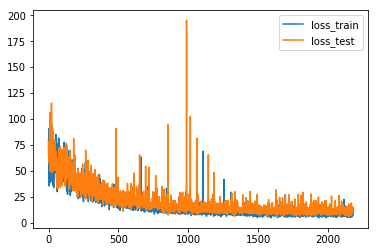

In [50]:
plt.plot(loss_list_train[300:], label='loss_train')
plt.plot(loss_list_test[300:], label='loss_test')
plt.legend()
plt.show()

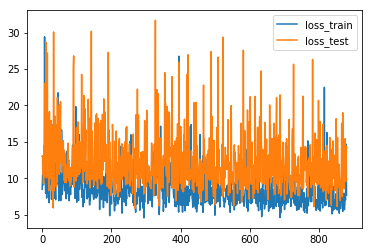

In [47]:
plt.plot(loss_list_train[1600:], label='loss_train')
plt.plot(loss_list_test[1600:], label='loss_test')
plt.legend()
plt.show()

In [39]:
X = Variable(AlexNet.features(Variable(X_tst[:100].type(torch.cuda.FloatTensor))).data.view(100,-1))            
y_pred_ = model(X)

In [40]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image, cmap='gray')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.show()

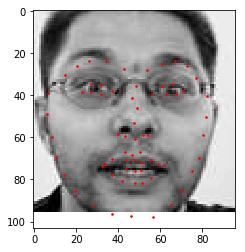

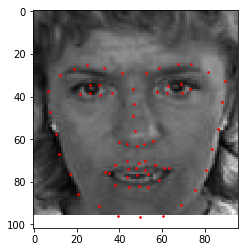

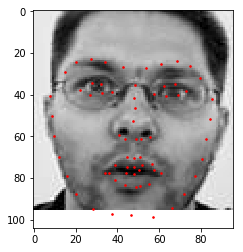

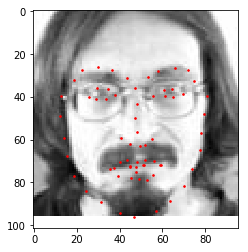

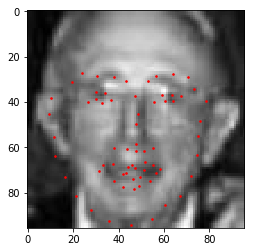

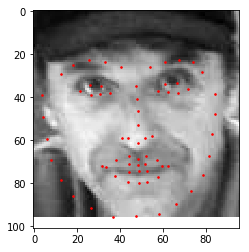

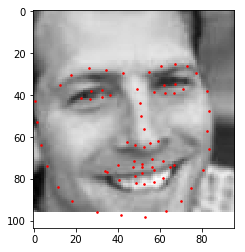

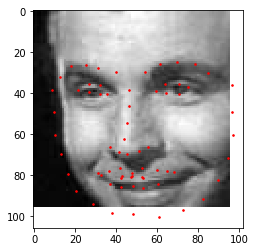

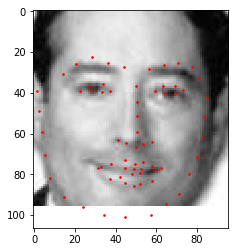

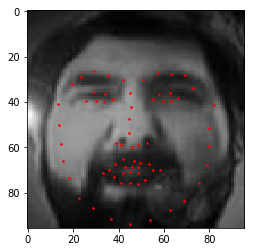

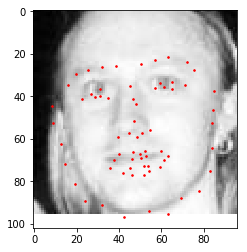

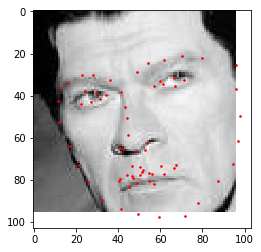

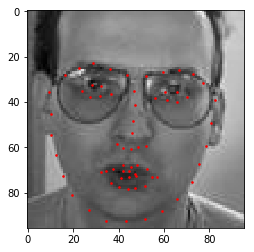

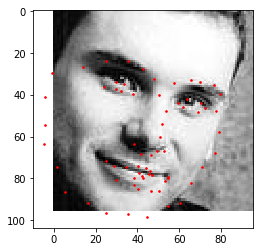

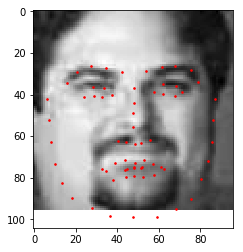

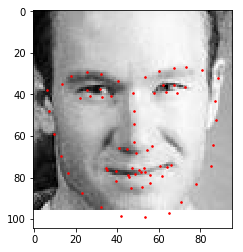

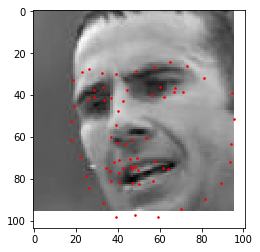

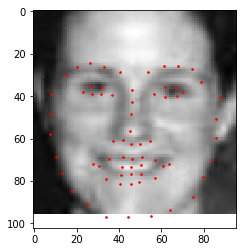

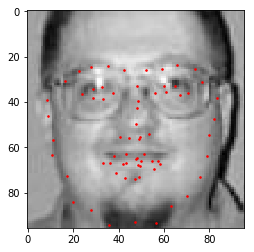

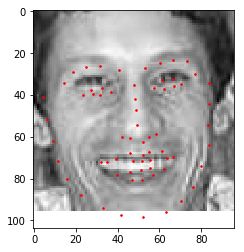

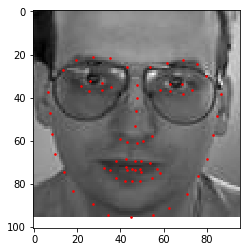

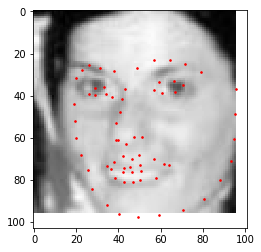

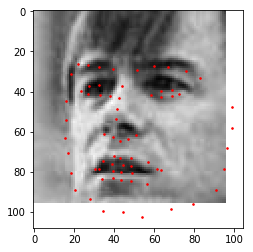

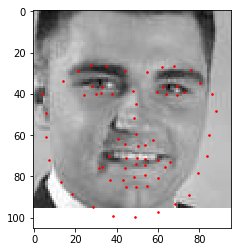

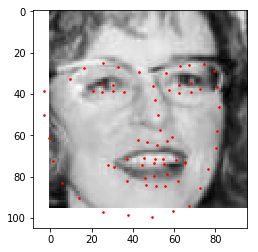

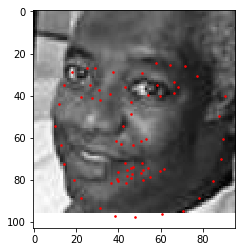

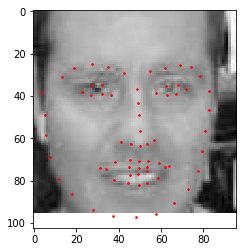

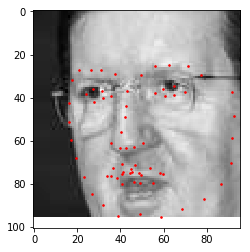

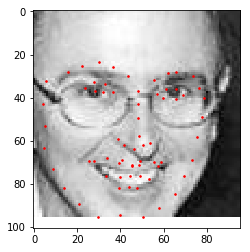

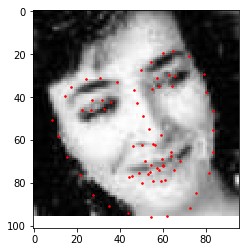

In [41]:
for i in range(30):
    landmarks = y_pred_.data[i].type(torch.FloatTensor).numpy().reshape(68,2)
    show_landmarks(X_test.numpy()[i], landmarks)

In [42]:
loss_fn = torch.nn.MSELoss()

In [43]:
loss_fn(y_pred_, Variable(y_test[:100].type(torch.cuda.FloatTensor)))

Variable containing:
 13.3083
[torch.cuda.FloatTensor of size 1 (GPU 0)]

### Часть 2 (опциональная)

Попробуйте обучить одну из архитектур на датасете. Сравните результаты с пунктом 1  

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: